# Gene expression

**Import**

In [1]:
# from second tutorial notebook (Part02)
import scanpy as sc
import pandas as pd
import scvelo as scv
import numpy as np
import seaborn as sns
from matplotlib.pyplot import rc_context
import matplotlib.pyplot as plt
import sklearn
import ipywidgets as widgets

# others
import re
import os

# first tutorial
import diffxpy.api as dxpy
import plotly.express as px

In [30]:
adata_input = '/home/astridkd/testis_singlecell/Workspaces/adahl/birc-project-akd/results/cluster_results/merged_norm_adata.h5ad'

In [31]:
adata = sc.read(adata_input)

In [32]:
#open human lncRNA txt file
HUM_lncRNAs = []
f = open('/home/astridkd/testis_singlecell/Workspaces/adahl/birc-project-akd/data/mapping/annotation_starsolo/lncRNAs.txt', "r")
for line in f:
    l = line.strip('\n')
    HUM_lncRNAs.append(l)
print(f)
f.close()

<_io.TextIOWrapper name='/home/astridkd/testis_singlecell/Workspaces/adahl/birc-project-akd/data/mapping/annotation_starsolo/lncRNAs.txt' mode='r' encoding='UTF-8'>


In [33]:
adata

AnnData object with n_obs × n_vars = 46782 × 20350
    obs: 'DATASET', 'batch', 'total_counts', 'n_genes_by_counts', 'percent_mito', 'prop_unspl', 'prop_spl', 'perc_MALAT1', 'n_genes', 'doublet_scores', 'predicted_doublets', 'SpermatogoniaA_score', 'SpermatogoniaB_score', 'SpermatocytesI_score', 'SpermatocytesII_score', 'Round.Spt_score', 'Elong.Spt_score', 'Sertoli_score', 'Macroph_score', 'Leydig_score', 'Endothelial_score', 'Undif. SG_score', 'Dif. SG_score', 'Lept. SC_score', 'Zyg. SC_score', 'Pach.Dipl. SC_score', 'Early round SD_score', 'Late round SD_score', 'Elong SD_score', 'SC_score', 'SC.I_score', 'SC.II_score', 'leiden_R.3', 'leiden_R.2', 'leiden_R.1', 'spermatogenesis_types', 'leiden_R.4', 'leiden_R.5', 'species'
    var: 'feature_types', 'chromosome', 'gene_ids-Bon', 'n_cells-Bon', 'highly_variable-Bon', 'means-Bon', 'dispersions-Bon', 'dispersions_norm-Bon', 'gene_ids-Chimp', 'n_cells-Chimp', 'highly_variable-Chimp', 'means-Chimp', 'dispersions-Chimp', 'dispersions_norm-

In [34]:
category_order=['Undif. SG','Dif. SG','SC.I','SC.II','Early round SD','Late round SD','Elong. SD','Sertoli','Macrophage']

In [35]:
palette_dict = {"Undif. SG":'lightblue',"Dif. SG":'blue',"SC.I":'lightgreen','SC.II':'green','Early round SD':'yellow','Late round SD':'orange','Elong. SD':'red','Sertoli':'pink','Macrophage':'brown'}

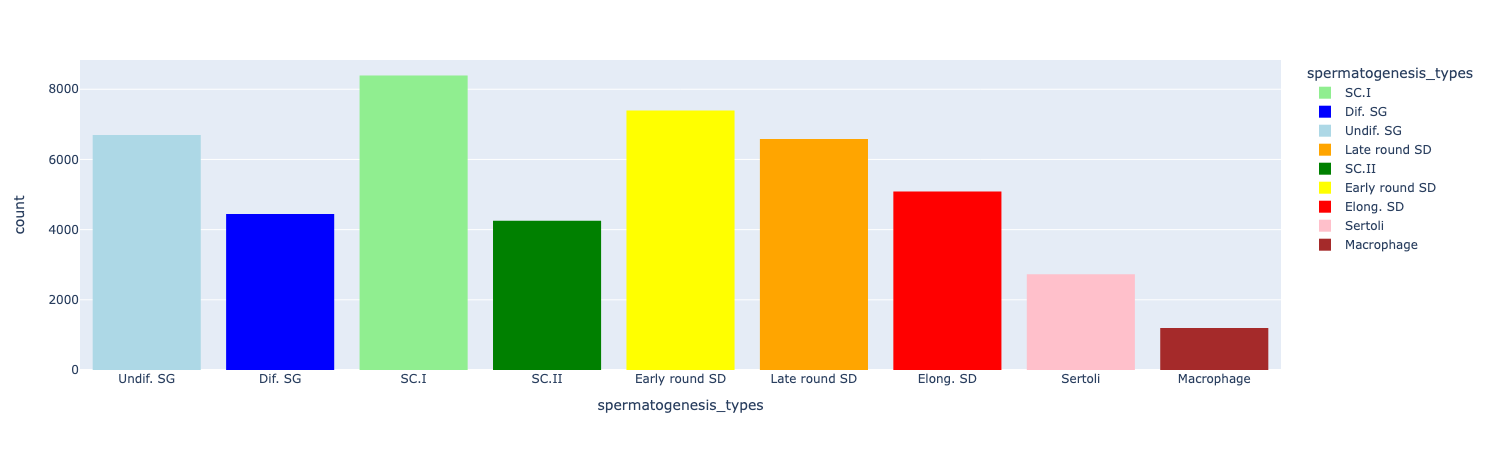

In [36]:
fig = px.histogram(adata.obs['spermatogenesis_types'], x='spermatogenesis_types', color='spermatogenesis_types',color_discrete_map=palette_dict)
fig.update_layout(
    xaxis=dict(
        categoryorder='array',
        categoryarray=category_order
    ),
    autosize=False,
    width=800,
    bargap=0.1,
    bargroupgap=0.1
)
fig.show()


In [37]:
# LINC genes, True/False vector
LINC = ['LINC' in i for i in adata.var_names] 

In [38]:
LINC_genes = adata[:,LINC].var_names

In [39]:
LINC_genes

Index(['LINC01409', 'LINC01128', 'LINC01134', 'LINC02780', 'LINC01672',
       'LINC02606', 'LINC01141', 'LINC00339', 'LINC01355', 'LINC01715',
       ...
       'LINC01203', 'LINC01282', 'LINC01284', 'LINC01278', 'LINC00630',
       'LINC01285', 'LINC00632', 'LINC00850', 'LINC00894', 'LINC00278'],
      dtype='object', length=849)

894 LINC genes are expressed across all species

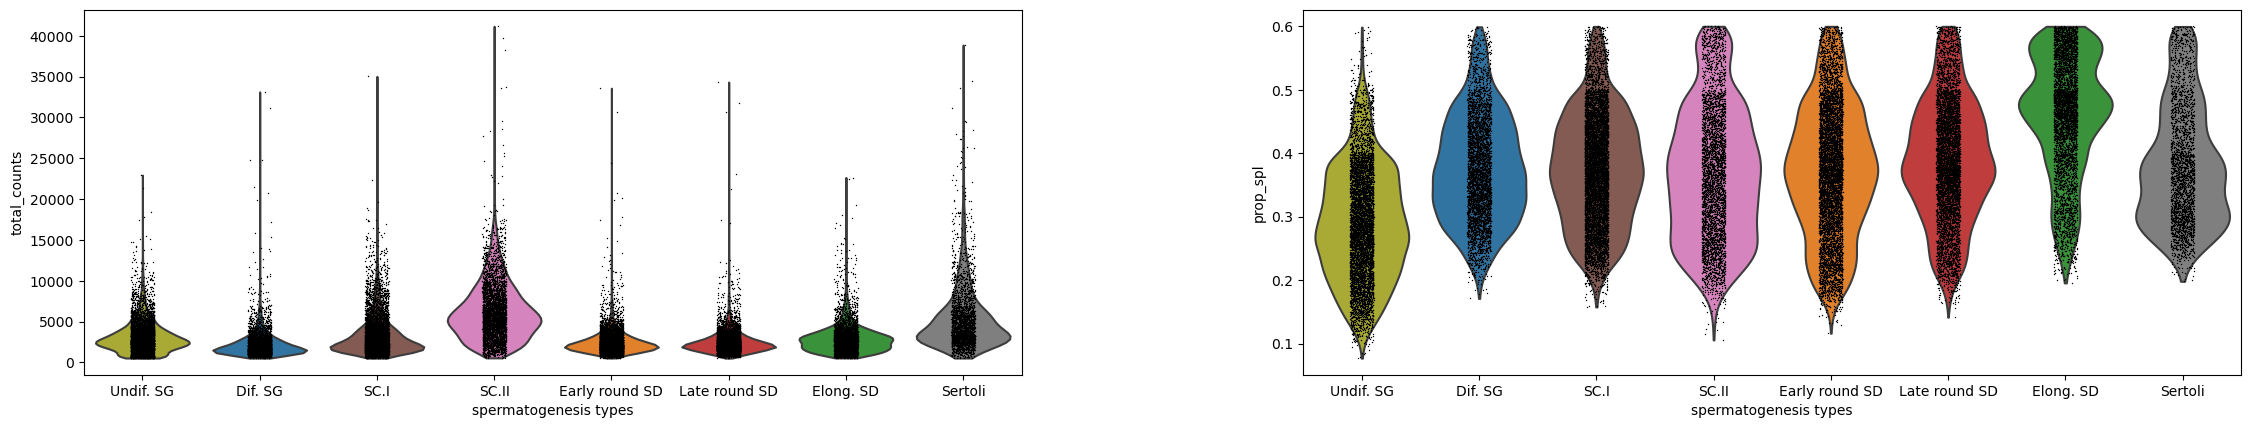

In [40]:
with rc_context({'figure.figsize': (10, 5)}):
    sc.pl.violin(adata, ['total_counts', 'prop_spl'], groupby='spermatogenesis_types', order=['Undif. SG','Dif. SG','SC.I','SC.II','Early round SD','Late round SD','Elong. SD','Sertoli'])

In [41]:
adata

AnnData object with n_obs × n_vars = 46782 × 20350
    obs: 'DATASET', 'batch', 'total_counts', 'n_genes_by_counts', 'percent_mito', 'prop_unspl', 'prop_spl', 'perc_MALAT1', 'n_genes', 'doublet_scores', 'predicted_doublets', 'SpermatogoniaA_score', 'SpermatogoniaB_score', 'SpermatocytesI_score', 'SpermatocytesII_score', 'Round.Spt_score', 'Elong.Spt_score', 'Sertoli_score', 'Macroph_score', 'Leydig_score', 'Endothelial_score', 'Undif. SG_score', 'Dif. SG_score', 'Lept. SC_score', 'Zyg. SC_score', 'Pach.Dipl. SC_score', 'Early round SD_score', 'Late round SD_score', 'Elong SD_score', 'SC_score', 'SC.I_score', 'SC.II_score', 'leiden_R.3', 'leiden_R.2', 'leiden_R.1', 'spermatogenesis_types', 'leiden_R.4', 'leiden_R.5', 'species'
    var: 'feature_types', 'chromosome', 'gene_ids-Bon', 'n_cells-Bon', 'highly_variable-Bon', 'means-Bon', 'dispersions-Bon', 'dispersions_norm-Bon', 'gene_ids-Chimp', 'n_cells-Chimp', 'highly_variable-Chimp', 'means-Chimp', 'dispersions-Chimp', 'dispersions_norm-

In [42]:
sc.tl.rank_genes_groups(adata, groupby='spermatogenesis_types', n_genes=50, key_added='DE_celltype') # diff.expressed genes in each cluster (t-test)

In [43]:
adata.uns['DE_celltype']['names']

rec.array([('AUTS2', 'CNBD1', 'FAM229A', 'PLCZ1', 'MALAT1', 'TTC28', 'DPY19L2', 'ERBB4', 'PARD3'),
           ('STAG1', 'LRRIQ1', 'C20orf144', 'CCSER1', 'NEAT1', 'HORMAD1', 'ANKRD62', 'GPC5', 'NALF1'),
           ('UBE2E2', 'TTC29', 'CCDC168', 'CCDC91', 'IGFBP7', 'LOC105373554', 'STRBP', 'ZBTB20', 'NRG3'),
           ('HELLS', 'MAPK10', 'HMGB4', 'STXBP5-AS1', 'RBMS3', 'ATRNL1', 'CRB1', 'CARMIL1', 'MTUS2'),
           ('JMJD1C', 'PACRG', 'PRM2', 'COL25A1', 'TSHZ2', 'AGBL4', 'C1QTNF3', 'SYNE2', 'CALN1'),
           ('amplicon-chrX-GAGE10/1/2A/13/12B/12C/12D/12E/12F/12G/12H/12J', 'SPAG16', 'LOC730098', 'SLC44A5', 'FTX', 'SCMH1', 'ANKRD30A', 'ARL15', 'NLGN1'),
           ('SPIDR', 'KCNT2', 'SIRT2', 'IQCM', 'LINC-PINT', 'ANKRD30A', 'ANKRD20A1', 'BBX', 'KLF12'),
           ('IL1RAPL1', 'LOC105372004', 'PPP2R2B', 'MGAT4C', 'BNC2', 'LOC100506207', 'CCDC38', 'SYNE1', 'BMPR1B'),
           ('SMC1B', 'LINC01500', 'PRM1', 'LINC00917', 'MIR99AHG', 'SETX', 'AP4B1-AS1', 'CADM1', 'AFF3'),
           (

In [44]:
top50 = pd.DataFrame(adata.uns['DE_celltype']['names']) # top 5 ranked genes for each cluster

top50.head()

Dif. SG Early round SD  Elong. SD Late round SD Macrophage          SC.I  \
0   AUTS2          CNBD1    FAM229A         PLCZ1     MALAT1         TTC28   
1   STAG1         LRRIQ1  C20orf144        CCSER1      NEAT1       HORMAD1   
2  UBE2E2          TTC29    CCDC168        CCDC91     IGFBP7  LOC105373554   
3   HELLS         MAPK10      HMGB4    STXBP5-AS1      RBMS3        ATRNL1   
4  JMJD1C          PACRG       PRM2       COL25A1      TSHZ2         AGBL4   

     SC.II  Sertoli Undif. SG  
0  DPY19L2    ERBB4     PARD3  
1  ANKRD62     GPC5     NALF1  
2    STRBP   ZBTB20      NRG3  
3     CRB1  CARMIL1     MTUS2  
4  C1QTNF3    SYNE2     CALN1

In [45]:
# all lncRNA genes in the top 50 genes
top50_lnc = {'Undif. SG':[],'Dif. SG':[],'SC.I':[],'SC.II':[],'Early round SD':[],'Late round SD':[],'Elong. SD':[],'Sertoli':[],'Macrophage':[]}

for celltype, genes in top50.items():
    for gene in genes:
        if gene in HUM_lncRNAs:
            top50_lnc[celltype].append(gene)

In [46]:
top50_lnc

{'Undif. SG': ['LOC105376755',
  'LOC442028',
  'MEF2C-AS1',
  'LOC107986770',
  'LOC105377171',
  'LINC01193'],
 'Dif. SG': ['LOC100507336',
  'LOC101927026',
  'LOC105377171',
  'LOC107985508',
  'LINC02645'],
 'SC.I': ['LOC105373554',
  'LOC100506207',
  'LINC01572',
  'LOC105376107',
  'MGC4859'],
 'SC.II': ['AP4B1-AS1',
  'LINC01206',
  'ADD3-AS1',
  'LOC440910',
  'ANKRD20A4-ANKRD20A20P',
  'LOC105379207',
  'MIR548A1HG',
  'LINC00879'],
 'Early round SD': ['LOC105372004',
  'LINC01500',
  'LOC101929492',
  'RBAKDN',
  'LOC105377110',
  'ZNF133-AS1',
  'LOC101928236',
  'LOC105372733',
  'LINC01609'],
 'Late round SD': ['STXBP5-AS1',
  'LINC00917',
  'LINC01492',
  'LINC02842',
  'LINC01500',
  'LRRC7-AS1',
  'LOC105375387',
  'LOC107984035',
  'PCDH9-AS3',
  'LOC112268205',
  'LOC105372733',
  'LOC101929563'],
 'Elong. SD': ['LOC102723490',
  'SPATA42',
  'LOC101928012',
  'LINC00265',
  'LOC100996249',
  'LINC01837',
  'MAP3K14-AS1',
  'LOC105375477',
  'LOC107985960'],
 'Serto

In [71]:
# all lncRNA genes in the top 50 genes
top50_lnc = {'Undif. SG':[],'Dif. SG':[],'SC.I':[],'SC.II':[],'Early round SD':[],'Late round SD':[],'Elong. SD':[],'Sertoli':[],'Macrophage':[]}

for celltype, genes in top50.items():
    for gene in genes:
        if gene in HUM_lncRNAs:
            top50_lnc[celltype].append(gene)

In [72]:
top50_lnc

{'Undif. SG': ['LOC105376755',
  'LOC442028',
  'MEF2C-AS1',
  'LOC107986770',
  'LOC105377171',
  'LINC01193'],
 'Dif. SG': ['LOC100507336',
  'LOC101927026',
  'LOC105377171',
  'LOC107985508',
  'LINC02645'],
 'SC.I': ['LOC105373554',
  'LOC100506207',
  'LINC01572',
  'LOC105376107',
  'MGC4859'],
 'SC.II': ['AP4B1-AS1',
  'LINC01206',
  'ADD3-AS1',
  'LOC440910',
  'ANKRD20A4-ANKRD20A20P',
  'LOC105379207',
  'MIR548A1HG',
  'LINC00879'],
 'Early round SD': ['LOC105372004',
  'LINC01500',
  'LOC101929492',
  'RBAKDN',
  'LOC105377110',
  'ZNF133-AS1',
  'LOC101928236',
  'LOC105372733',
  'LINC01609'],
 'Late round SD': ['STXBP5-AS1',
  'LINC00917',
  'LINC01492',
  'LINC02842',
  'LINC01500',
  'LRRC7-AS1',
  'LOC105375387',
  'LOC107984035',
  'PCDH9-AS3',
  'LOC112268205',
  'LOC105372733',
  'LOC101929563'],
 'Elong. SD': ['LOC102723490',
  'SPATA42',
  'LOC101928012',
  'LINC00265',
  'LOC100996249',
  'LINC01837',
  'MAP3K14-AS1',
  'LOC105375477',
  'LOC107985960'],
 'Serto

In [73]:
lnc_count = {}

for celltype, genes in top50_lnc.items():
    lnc_count[celltype]=len(genes)

In [74]:
lnc_count

{'Undif. SG': 6,
 'Dif. SG': 5,
 'SC.I': 5,
 'SC.II': 8,
 'Early round SD': 9,
 'Late round SD': 12,
 'Elong. SD': 9,
 'Sertoli': 6,
 'Macrophage': 8}

In [ ]:
# to compare to a certain gene across groups
# no. 4 in SC.II
with rc_context({'figure.figsize': (11, 5)}):
    sc.pl.violin(adata, ['LOC101927284'], groupby='spermatogenesis_types', order=['Undif. SG','Dif. SG','SC.I','SC.II','Early round SD','Late round SD','Elong. SD','Sertoli'])

NameError: name 'rc_context' is not defined

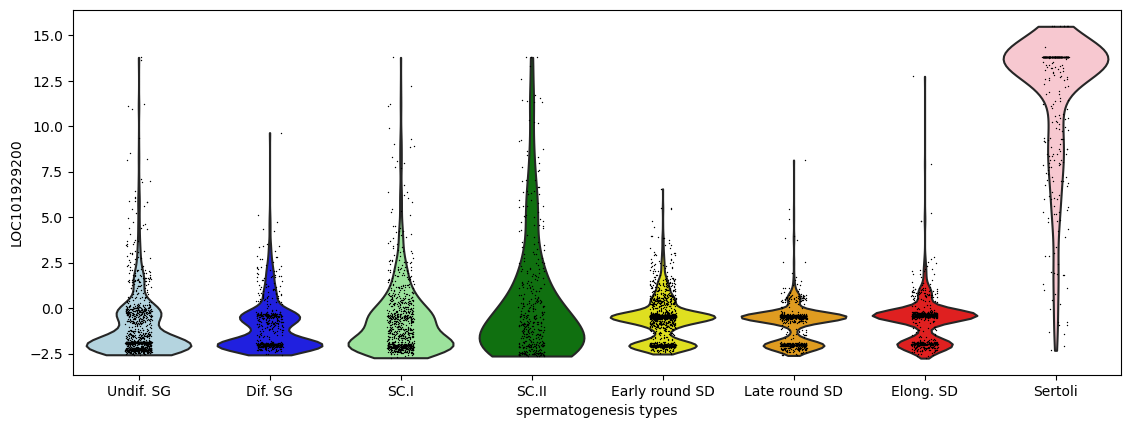

In [26]:
# no. 1 in sertoli
with rc_context({'figure.figsize': (11, 5)}):
    sc.pl.violin(adata, ['LOC101929200'], groupby='spermatogenesis_types', order=['Undif. SG','Dif. SG','SC.I','SC.II','Early round SD','Late round SD','Elong. SD','Sertoli'])

In [75]:
to_plot = []
to_plot = [top50_lnc[celltype][0] for celltype in top50_lnc]

In [76]:
to_plot

['LOC105376755',
 'LOC100507336',
 'LOC105373554',
 'AP4B1-AS1',
 'LOC105372004',
 'STXBP5-AS1',
 'LOC102723490',
 'MALAT1',
 'MALAT1']

In [ ]:
sc.pl.dotplot(adata.layers[''], to_plot, groupby='spermatogenesis_types', categories_order=['Undif. SG','Dif. SG','SC.I','SC.II','Early round SD','Late round SD','Elong. SD','Sertoli','Macrophage'])

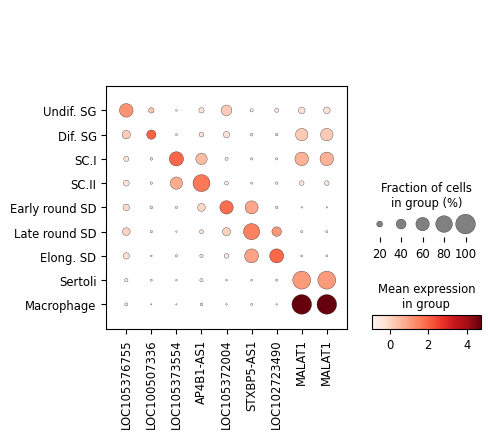

In [49]:
sc.pl.dotplot(adata, to_plot, groupby='spermatogenesis_types', categories_order=['Undif. SG','Dif. SG','SC.I','SC.II','Early round SD','Late round SD','Elong. SD','Sertoli','Macrophage'])

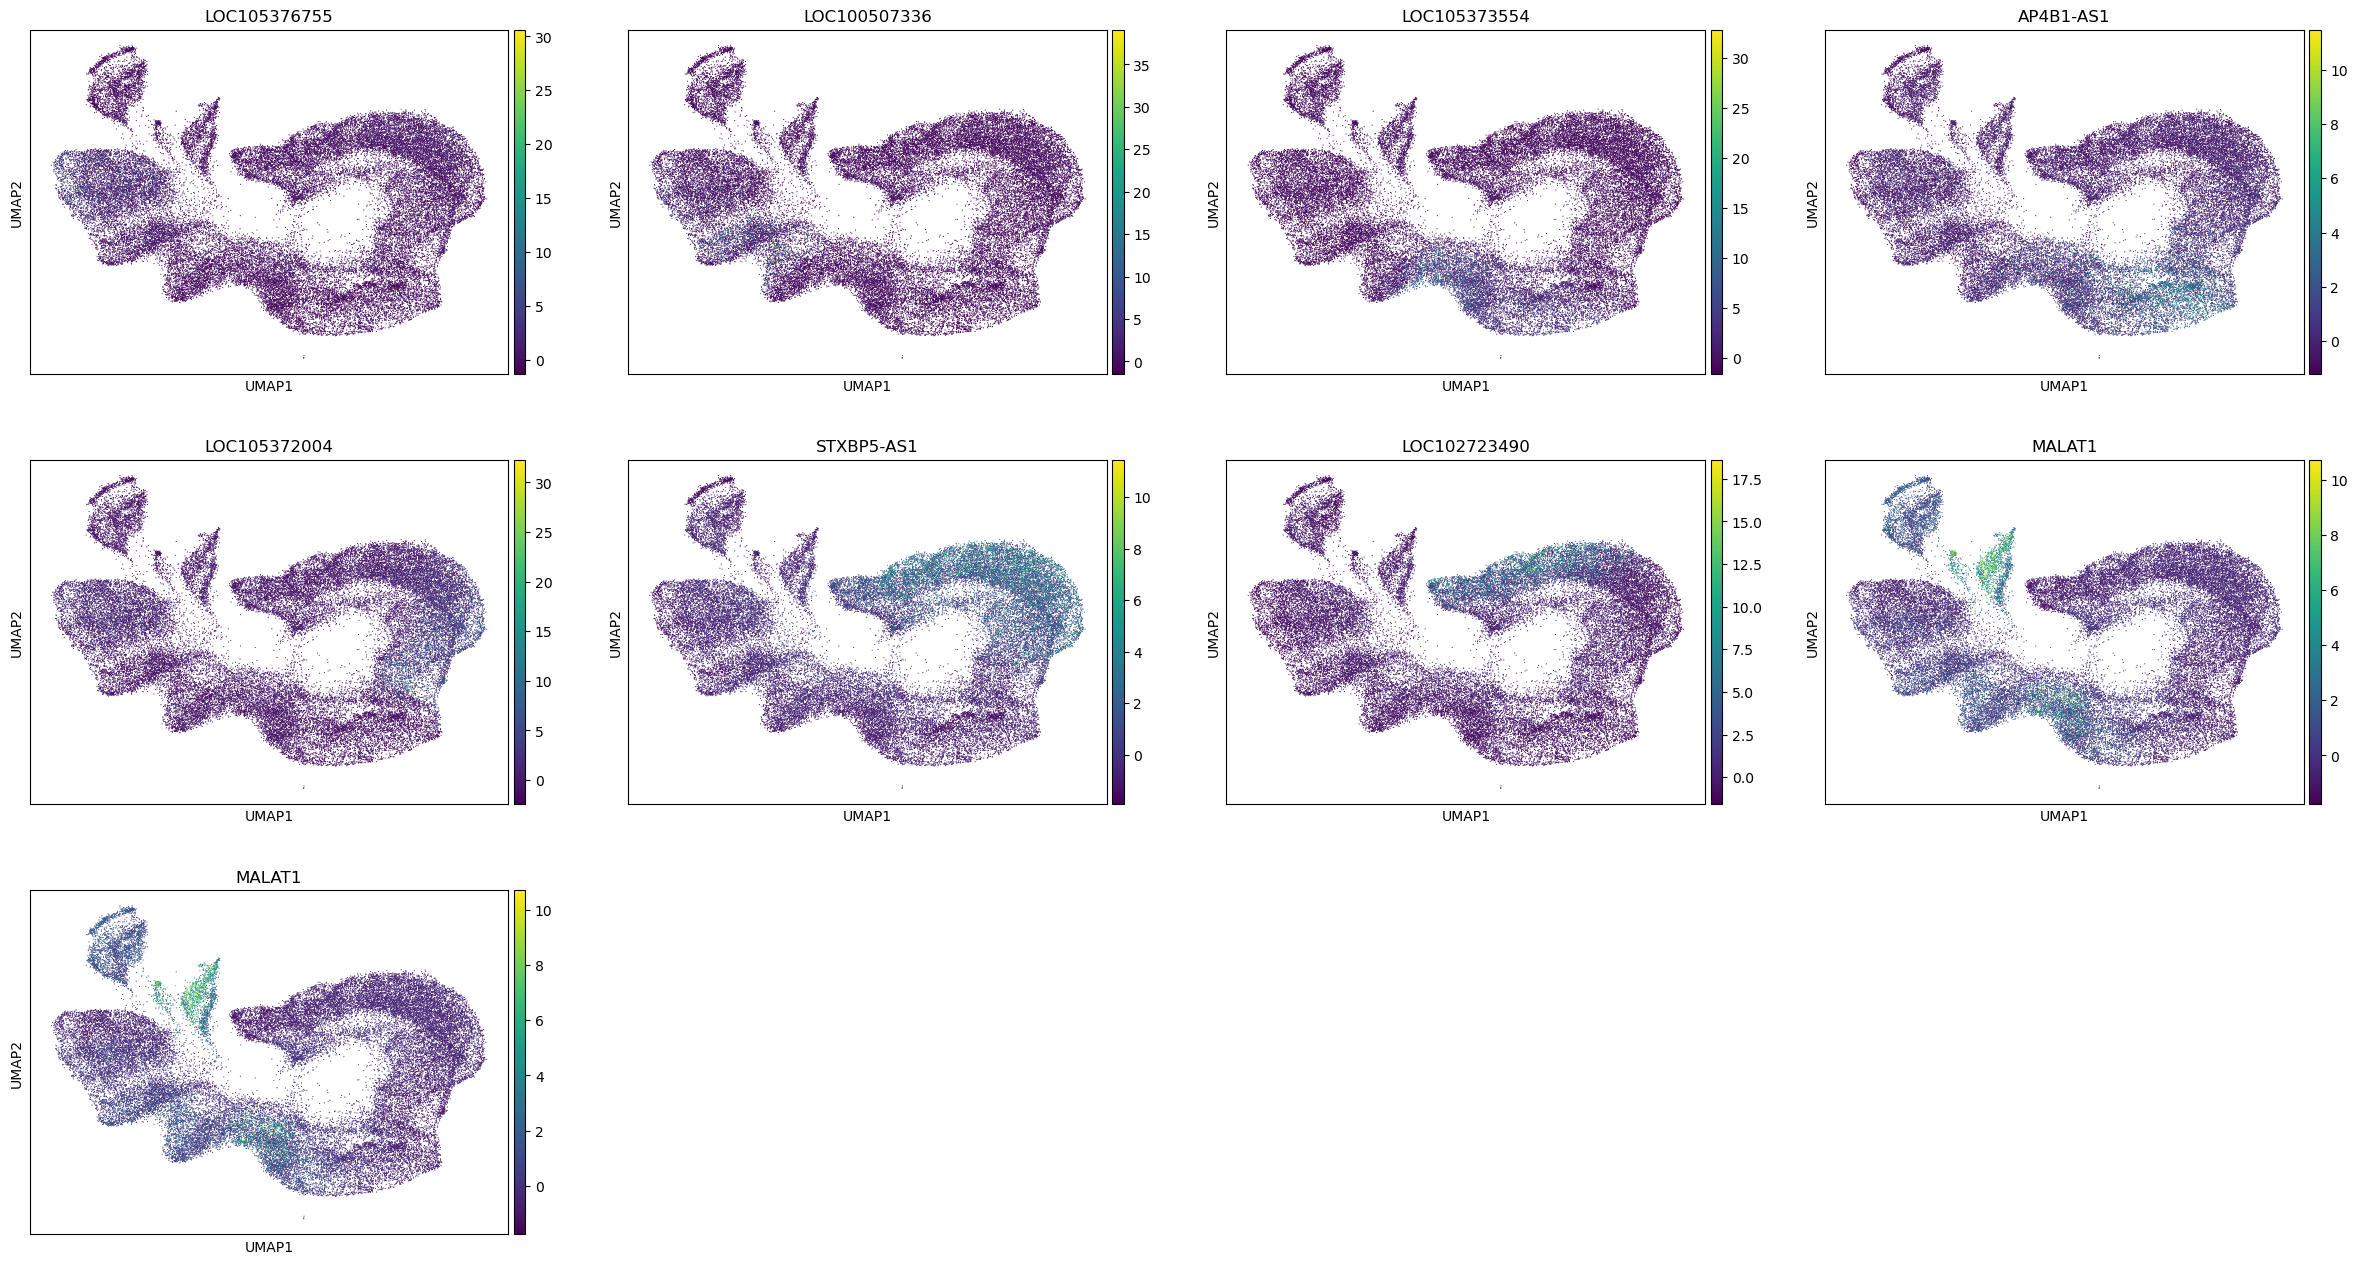

In [63]:
# UMAP colored by the top genes
sc.plotting.umap(adata, color=to_plot)